<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have access to a GPU. To do so, please do the followings:
1. Edit
2. Notebook settings
3. Select GPU for 'Hardware accelerator'
4. Save

You ready to go :-)

This practice presents the standard workflow to train a convolutional neural network (CNN) for image segmentation and detection. We will be playing with a dataset of images from "Where is Wally?". Let's see if CNN can help to find him.

## Step 0: Configuration

Some Python packages...

In [ ]:
import os
import random
from PIL import Image
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

We will be using the tools from PyTorch for the Deep Learning aspects of the pipeline.

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

Looking at the working directory before cloning the Github repository

In [ ]:
pwd

'/content'

Cloning the Github repository and setting the working directory inside it

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
   c801657..41c4087  main       -> origin/main
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Updating c801657..41c4087
Fast-forward
 code/inference.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


Here after we are loading functions from the cloned Github repository, eg data augmentation operations, UNet architecture, utilitary functions.

In [ ]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor, find_bounding_box_coords, threshold_mask
from loader import WaldoLoader, resize_image
from model import Waldo_UNet
from training import train_model, update_optimizer
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate
from inference import patchify_test_image, reconstruct_image_from_patches, load_andy_model, predict_with_pretrained_model

And... setting some parameters. Have a quick look at them. If keen, have a play with them after the practice to see the effect of each of them. Model-builders spend a lot of time fine-tuning some of these parameters (e.g., size_batch, size_patch) to optimise their model training.

In [ ]:
# Patch towards the whole dataset
path_dataset_folder = "../dataset"
# Folder name containing the training images
path_image_folder = "images"
# Filename containing the annotations for the training images
fname_annotation = "annotations.csv"
# Image extension
extension = ".jpg"
# Fraction of the training that that will be used to train the network, remaining will be used as validation subset
ratio_train_dataset = 0.8
# Random seed
int_seed_split = 7109
# Size of the patches, extracted from the full sized images
size_patch = 160
# Sequence of data augmentation transforms
sequence_data_augmentation = Sequence([RandomHorizontalFlip(), RandomTranslate(0.2)], probs=0.6)
# Size of the batch used for training
size_batch = 16
# Filename of the trained model
fname_trained_model = "model.pt"
# Number of training epochs
n_epoch = 2 #200 # Given the limited time of the workshop

## Step 1: Data exploration and preparation

We are here fetching the filenames of the training images. They are hosted on the Github repository, under "dataset/images". We will use these images to run the training, while a couple of images have been randomly set apart for testing the model once trained.

In [ ]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the training dataset...".format(len(list_fname_im)))

Found 35 images in the training dataset...


We will perform a "supervised learning", which means we will optimise the model weights by backprogating the measured error between the model predictions and the ground-truth. The ground-truth have been defined by an (imperfect) human being, as a bounding box around Wally's head, and recorded in the csv file "dataset/annotations.csv". The coordinates of the bounding boxes are stored in this file.

In [ ]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.tail())

Getting annotations...
   filename  width  height  class  xmin  ymin  xmax  ymax
33  031.jpg   3544    2226  waldo  2202  1501  2257  1560
34  032.jpg   1772    1116  waldo   317   709   346   745
35  033.jpg   1511    1178  waldo   327   922   373   974
36  034.jpg   3566    2257  waldo  3057   873  3101   933
37  035.jpg   1848    1158  waldo   177   840   211   877


From the bounding box coordinates, we can generate a binary mask:
- 1 is assigned to pixels inside the bounding box
- 0 is assigned to pixels outside the bounding box

These binary masks are our targets: the model is trained to produce binary masks with 1s around Wally's head.

In [ ]:
print("Saving binary mask from annotations as ground-truth...")
for fname_im in list(df_annotations["filename"].unique()):
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        df_cur = df_annotations[df_annotations["filename"]==fname_im]
        mask = create_binary_mask(list_bbox_coords=df_cur[["xmin", "ymin", "xmax", "ymax"]].values.tolist(),
                              im_ref_width=df_cur["width"].values.tolist()[0],
                              im_ref_height=df_cur["height"].values.tolist()[0])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...


TODO: Look at class imbalance

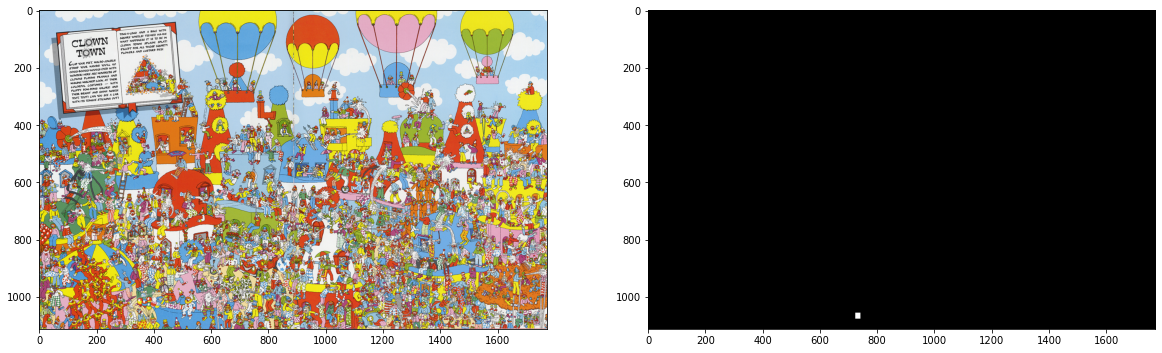

In [ ]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))

fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

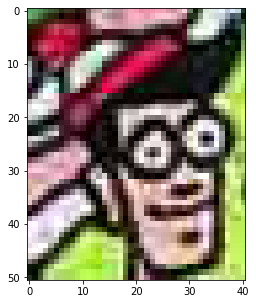

In [ ]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png")).convert("L")
np_gt = np.array(gt)
np_gt_labeled, n_waldo = label(np_gt, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    gt_cur = (np_gt_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(gt_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(np_im[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

## Step 2: Training data loading

In [ ]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [ ]:
print(len(df_annotations[df_annotations["subset"] == "training"]["filename"].unique()))

28


In [ ]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"].unique()
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 160 x 160 pixels^2 ...


In [ ]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"].unique()
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 160 x 160 pixels^2 ...


In [ ]:
len(dataset_train), len(dataset_valid)

(3163, 638)

(160, 160, 3)


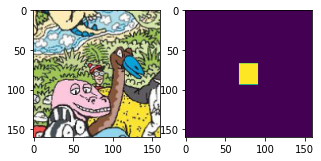

(160, 160, 3)


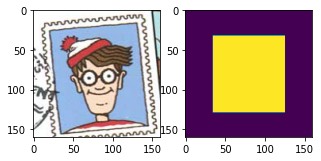

(160, 160, 3)


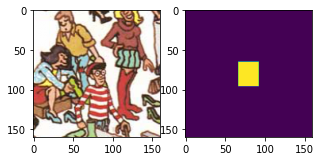

(160, 160, 3)


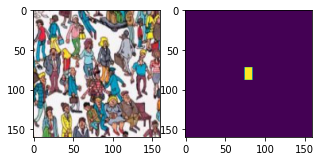

(160, 160, 3)


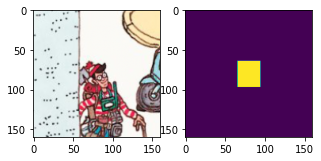

(160, 160, 3)


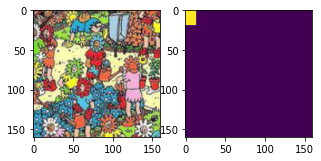

(160, 160, 3)


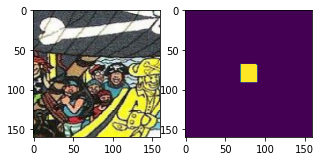

(160, 160, 3)


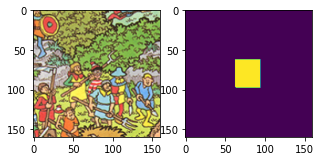

In [ ]:
for i, g in zip(dataset_valid.list_patch_positive_img, dataset_valid.list_patch_positive_gt):
  fig = plt.figure(figsize=(5, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(i)
  plt.subplot(1, 2, 2)
  plt.imshow(g)
  print(i.shape)
  plt.show()

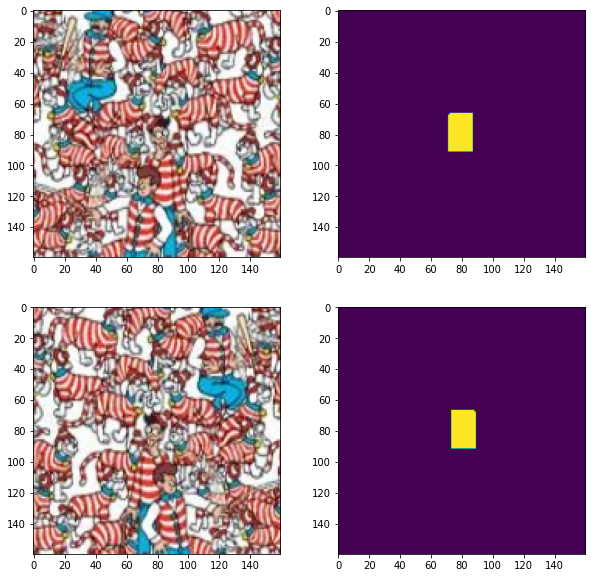

In [ ]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
flip = Sequence([RandomHorizontalFlip()], probs=1)
sample_flip, sample_gt_flip = flip(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_flip)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_flip)
plt.show()

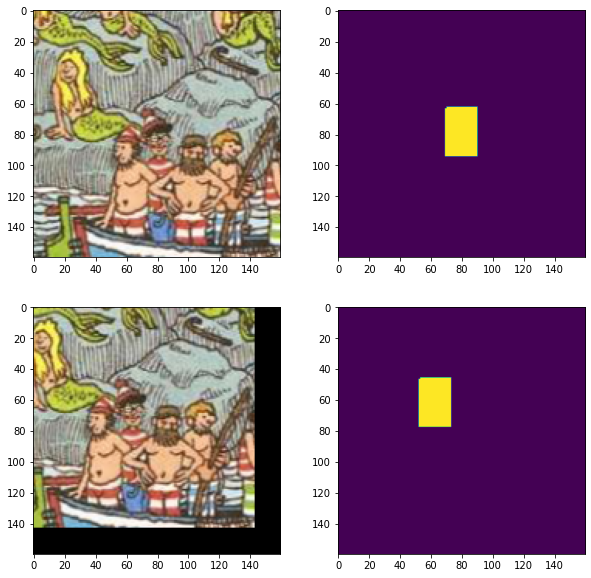

In [ ]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
translate = Sequence([RandomTranslate(0.2)], probs=1)
sample_translate, sample_gt_translate = translate(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_translate)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_translate)
plt.show()

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

TODO: FIX DISPLAY GT BELOW

tensor(5.7618e-09) tensor(1.0000)
tensor([0, 1]) torch.Size([16, 1, 160, 160]) torch.Size([16, 3, 160, 160])


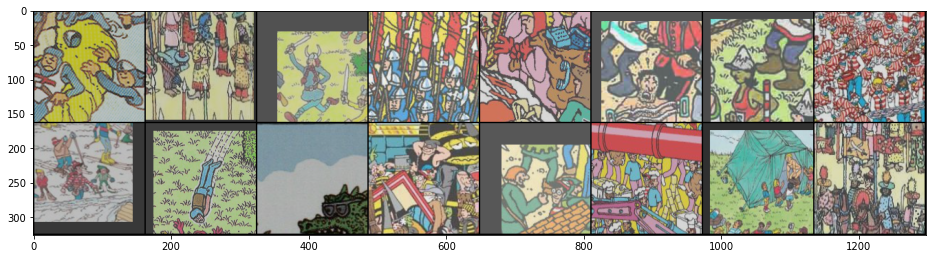

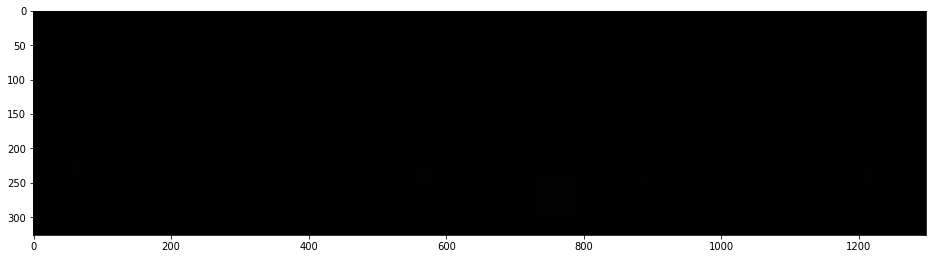

In [ ]:
image_expl, label_expl = iter(loader_train).next()
print(image_expl.mean(), image_expl.std())
print(label_expl.unique(), label_expl.size(), image_expl.size())
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(image_expl, normalize=True))
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(label_expl))

## Step 3: Model training

In [ ]:
model = Waldo_UNet(n_channels=3).cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)

In [ ]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=n_epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch#1 -- Train loss: -0.026 -- Validation loss: -0.008
Epoch#2 -- Train loss: -0.016 -- Validation loss: -0.013


In [ ]:
#optimizer = update_optimizer(optimizer, lr=0.01)
#model_trained = train_model(model_trained, optimizer, loader_train, dataset_validation=loader_valid, n_epoch=100)
# etc.
# Give recipe TODO

In [ ]:
torch.save(model_trained, fname_trained_model)

## Step 4: Inference on independent data

In [ ]:
pretrained_model = load_andy_model()

Loading pretrained model ...


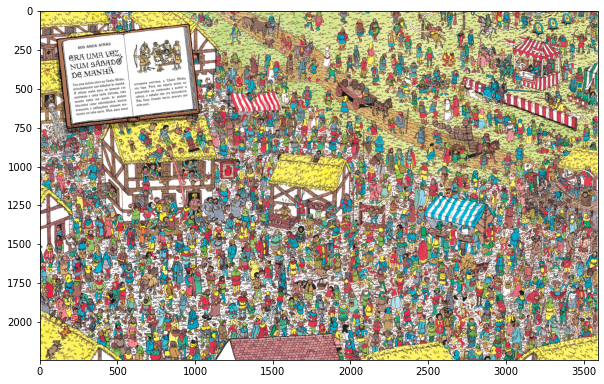

In [ ]:
from loader import load_image
fname_rdm_test_image = random.choice([os.path.join(path_dataset_folder, "images_test", i) for i in os.listdir(os.path.join(path_dataset_folder, "images_test")) if i.endswith(".jpg")])
image_test = load_image(fname_rdm_test_image)

plt.figure(figsize=(10, 10))
plt.imshow(image_test)
plt.show()

In [ ]:
image_test_resized, predictions, predictions_alpha = predict_with_pretrained_model(image_test, pretrained_model)

Resizing input image ...
Extracting patches ...
Running predictions ...


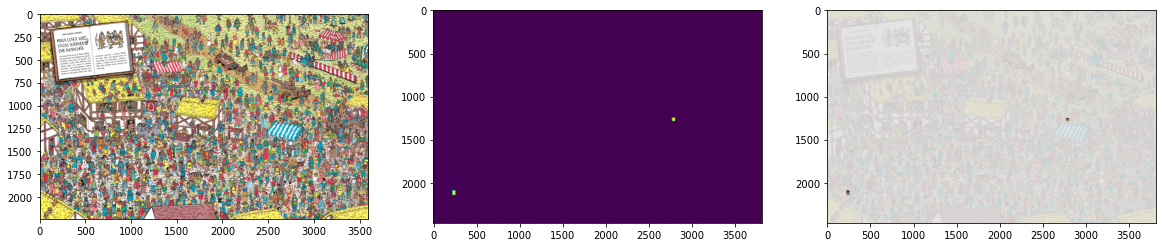

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(image_test)
plt.subplot(1, 3, 2)
plt.imshow(predictions)
plt.subplot(1, 3, 3)
plt.imshow(predictions_alpha)
plt.show()

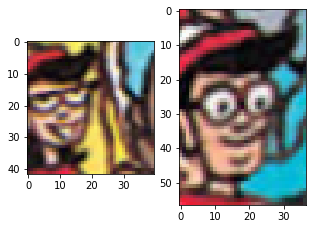

In [ ]:
predictions_thr = threshold_mask(predictions, 0.5)
np_pred_labeled, n_waldo = label(predictions_thr, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    pred_cur = (np_pred_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(pred_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(image_test_resized[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

In [ ]:
#model_trained.eval()
#stack_patch = np.swapaxes(np.swapaxes(stack_patch, 3, 1), 3, 2)
#print(stack_patch.shape)
#list_pred = []
#for i_pred, idx in enumerate(range(0, stack_patch.shape[0], size_batch)):
#    tensor_test = torch.from_numpy(stack_patch[i_pred * size_batch : (i_pred + 1) * size_batch, :])
#    tensor_test = tensor_test.cuda().float()
#    pred = model_trained(tensor_test)
#    pred = pred[:, 1:, :, :]
#    list_pred.append(np.array(pred))
#stack_pred = np.stack(list_pred)

TODO: give perspectives to further improve model